# Evaluating our Deep Learning Models on Test Data

In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.models import load_model
import model_evaluation_utils as meu
%matplotlib inline

Using plaidml.keras.backend backend.


In [2]:
# load saved models
basic_cnn = load_model('saved_models/cnn_model_with_ragularization.h5')
img_aug_cnn = load_model('saved_models/cnn_model_with_image_augmentation.h5')
tl_cnn = load_model('saved_models/pre_trained_tlearn.h5')
tl_img_aug_cnn = load_model('saved_models/pre_trained_with_augmentation_tlearn.h5')
tl_img_aug_finetune_cnn = load_model('saved_models/pre_trained_fine_tune_with_augmentation_tlearn.h5')

INFO:plaidml:Opening device "opencl_amd_hainan.0"


In [3]:
# load other configurations
IMG_DIM = (150, 150)
input_shape = (150, 150, 3)
num2class_label_transformer = lambda l: ['cat' if x == 0 else 'dog' for x in l]
class2num_label_transformer = lambda l: [0 if x == 'cat' else 1 for x in l]

In [4]:
# load VGG model for bottleneck features
from keras.applications import vgg16
from keras.models import Model
import keras

In [5]:
vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                  input_shape=input_shape)
output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)
vgg_model.trainable = False

In [6]:
def get_bottleneck_features(model, input_imgs):
    features = model.predict(input_imgs, verbose=0)
    return features

In [7]:
IMG_DIM = (150, 150)

test_files = glob.glob('test_data/*')
test_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in test_files]
test_imgs = np.array(test_imgs)
test_labels = [fn.split('\\')[1].split('.')[0].strip() for fn in test_files]

test_imgs_scaled = test_imgs.astype('float32')
test_imgs_scaled /= 255
test_labels_enc = class2num_label_transformer(test_labels)

print('Test dataset shape:', test_imgs.shape)
print(test_labels[0:5], test_labels_enc[0:5])

Test dataset shape: (1000, 150, 150, 3)
['cat', 'cat', 'cat', 'cat', 'cat'] [0, 0, 0, 0, 0]


### Model 1: Basic CNN with regularization Performance

In [8]:
predictions = basic_cnn.predict_classes(test_imgs_scaled, verbose=0)
predictions = num2class_label_transformer(predictions)
meu.display_model_performance_metrics(true_labels=test_labels, predicted_labels=predictions, 
                                      classes=list(set(test_labels)))

Model Performance metrics:
------------------------------
Accuracy: 0.754
Precision: 0.7591
Recall: 0.754
F1 Score: 0.7528

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         cat       0.72      0.82      0.77       500
         dog       0.80      0.68      0.74       500

    accuracy                           0.75      1000
   macro avg       0.76      0.75      0.75      1000
weighted avg       0.76      0.75      0.75      1000



### Model 2: Basic CNN with Image Augmentation Performance

In [9]:
predictions = img_aug_cnn.predict_classes(test_imgs_scaled, verbose=0)
predictions = num2class_label_transformer(predictions)
meu.display_model_performance_metrics(true_labels=test_labels, predicted_labels=predictions, 
                                      classes=list(set(test_labels)))

Model Performance metrics:
------------------------------
Accuracy: 0.805
Precision: 0.8154
Recall: 0.805
F1 Score: 0.8034

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         cat       0.87      0.71      0.79       500
         dog       0.76      0.90      0.82       500

    accuracy                           0.81      1000
   macro avg       0.82      0.80      0.80      1000
weighted avg       0.82      0.81      0.80      1000



### Model 3: Transfer Learning — Pre-trained CNN as a Feature Extractor Performance

In [10]:
test_bottleneck_features = get_bottleneck_features(vgg_model, test_imgs_scaled)

predictions = tl_cnn.predict_classes(test_bottleneck_features, verbose=0)
predictions = num2class_label_transformer(predictions)
meu.display_model_performance_metrics(true_labels=test_labels, predicted_labels=predictions, 
                                      classes=list(set(test_labels)))

Model Performance metrics:
------------------------------
Accuracy: 0.886
Precision: 0.8865
Recall: 0.886
F1 Score: 0.886

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         cat       0.87      0.90      0.89       500
         dog       0.90      0.87      0.88       500

    accuracy                           0.89      1000
   macro avg       0.89      0.89      0.89      1000
weighted avg       0.89      0.89      0.89      1000



### Model 4: Transfer Learning — Pre-trained CNN as a Feature Extractor with Image Augmentation Performance

In [11]:
predictions = tl_img_aug_cnn.predict_classes(test_imgs_scaled, verbose=0)
predictions = num2class_label_transformer(predictions)
meu.display_model_performance_metrics(true_labels=test_labels, predicted_labels=predictions, 
                                      classes=list(set(test_labels)))

Model Performance metrics:
------------------------------
Accuracy: 0.95
Precision: 0.9514
Recall: 0.95
F1 Score: 0.95

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         cat       0.98      0.92      0.95       500
         dog       0.93      0.98      0.95       500

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000



### Model 5: Transfer Learning — Pre-trained CNN with Fine-tuning and Image Augmentation Performance

In [12]:
predictions = tl_img_aug_finetune_cnn.predict_classes(test_imgs_scaled, verbose=0)
predictions = num2class_label_transformer(predictions)
meu.display_model_performance_metrics(true_labels=test_labels, predicted_labels=predictions, 
                                      classes=list(set(test_labels)))

Model Performance metrics:
------------------------------
Accuracy: 0.937
Precision: 0.9371
Recall: 0.937
F1 Score: 0.937

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         cat       0.95      0.93      0.94       500
         dog       0.93      0.95      0.94       500

    accuracy                           0.94      1000
   macro avg       0.94      0.94      0.94      1000
weighted avg       0.94      0.94      0.94      1000



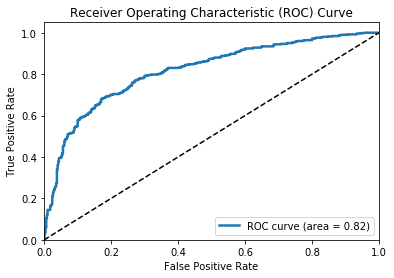

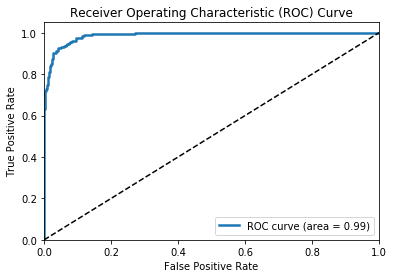

In [13]:
# worst model - basic CNN 
meu.plot_model_roc_curve(basic_cnn, test_imgs_scaled, 
                         true_labels=test_labels_enc, 
                         class_names=[0, 1]) 

# best model - transfer learning with fine-tuning & image augmentation 
meu.plot_model_roc_curve(tl_img_aug_finetune_cnn, test_imgs_scaled, 
                         true_labels=test_labels_enc, 
                         class_names=[0, 1])